# Are Upsets More Likely Between Division Rivals in the NFL?
Ben Namovicz

### Introduction
In week 14 of the 2018 NFL season, the 6-6 Miami Dolphins beat the 9-3 New England Patriots in [miraculous](https://www.youtube.com/watch?v=uiz87A3RpEw "The Miracle in Miami") fashion. The Patriots would go on to win the superbowl that season while the Dolphins didn't even make the playoffs. The very next year, the 4-11 Dolphins beat the 12-3 Patriots in another big [upset](https://www.youtube.com/watch?v=nnsq4iGCTyI "The Fail in Foxboro"). Taken alone these games are a remarkable story, but they also fit into a common narrative in sports.

It is often claimed that division rivals have an easier time pulling off upsets than out of division opponents. The two previously discussed in-division upsets would seem to support this claim, but does this claim hold up to rigerous data analysis? In this tutorial we will use Python's data analysis tools to put this claim to the test.


### Contents
- [Background Information](#background)
- [Data Collection](#collection)
- [Data Processing](#processing)
- [Data Analysis](#analysis)
- [Prediction](#prediction)
- [Conclusion](#conclusion)

<a name='background'></a>
## Background Information
There are 32 teams in the NFL. These teams are divided into 2 conferences of 16 teams each. The conferences are further subdivided into divisions of 4 teams each, leaving the NFL with 8 total divisions. These divisions can be seen below:

<p style="text-indent: 225px;">
    <b>AFC:</b>
</p>

| East                 | West                 | North               | South                |
| :----                | :---                 | :---                | :---                 | 
| Buffalo Bills        | Denver Broncos       | Baltimore Ravens    | Houston Texans       |
| Miami Dolphins       | Kansas City Chiefs   | Cincinnati Bengals  | Indianapolis Colts   | 
| New England Patriots | Las Vegas Raiders    | Cleveland Browns    | Jacksonville Jaguars |
| New York Jets        | Los Angeles Chargers | Pittsburgh Steelers | Tennessee Titans     | 


    
<p style="text-indent: 225px;">
    <b>NFC:</b>
</p>

| East                     | West                | North             | South                |
| :---                     | :---                | :---              | :---                 |
| Dallas Cowboys           | Arizona Cardinals   | Chicago Bears     | Atlanta Falcons      |
| New York Giants          | Los Angeles Rams    | Detroit Lions     | Carolina Panthers    |
| Philadelphia Eagles      | San Fransisco 49ers | Green Bay Packers | New Orleans Saints   |
| Washington Football Team | Seattle Seahawks    | Minnesota Vikings | Tampa Bay Buccaneers |

An NFL team plays 16 games in a [season](https://operations.nfl.com/the-game/creating-the-nfl-schedule/ "How NFL Schedules are Made"). 6 of these games are in division games, so a team will play every team in it's division twice every year. The other 10 games are played out of division, and the matchups for these games change every year. A team will never play an out of division opponent more than once in a season. This creates a situation where a team is much more familiar with teams in their divison. This is where the logic for the claim we are testing comes from. If you face the same team twice every year, you should know how they work, and this should level the playing field between good teams and bad teams.

<a name='collection'></a>
## Data Collection

In order to test our hypothesis we will definitely need records of who wins and loses each game. We will also need some measure of what counts as an 'upset'. The most obvious way to quantify upsets would be to use win-loss records, but this is flawed for two big reasons:
1. Teams start at 0-0 each season, so early season games will have to be thrown out
2. Records can be decieving. A 5-4 record against good teams should be better than a 6-3 record against terrible teams.

Luckily there is an approach that solves both of these problems. The [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) Is a method of ranking teams based on their performance over time. For this project we will use [538's Historical NFL Elo Ratings](https://projects.fivethirtyeight.com/complete-history-of-the-nfl/). The complete dataset, which includes Elo scores and game results, can be found [here](https://github.com/fivethirtyeight/data/tree/master/nfl-elo). An in depth explaination of how the Elo ratings are calculated can be found [here](https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/). For our purposes we just need to know that a team's Elo score is a representation of how good they are with better teams having higher scores. As we will see [later], these scores can be used to calculate predicted probability of winning or predicted point spread.


Now let's get started by importing some modules. Here are the modules we will be using:
- [Numpy](https://numpy.org/): Numpy is a python representation of arrays. It is needed for this project because pandas dataframes are built on Numpy arrays.
- [Pandas](https://pandas.pydata.org/): We will be using Pandas dataframes to store and manipulte our data. A dataframe is a table of data stored like a database. Each row of the dataframe represents a single observation (in our case, a football game) and every column represents an attribute of that game (when it was played, team 1's score, team 2's score, etc.). Pandas includes a lot of useful methods for quickly preforming calcualtions across all the data.
- [Scikit learn](https://scikit-learn.org/stable/): Scikit-learn is a library used for machine learning. We will be using it to preform regression on our data and test whether we can predict future results. Since we don't want to wait for the future to test our models, we will simply withold some data from the model and test on that.
- [Matplotlib](https://matplotlib.org/): Matplotlib is used for data visualization. We will be using it to make graphs so we can easily spot trends in our data.
- [Scipy](https://www.scipy.org/): We will be using Scipy statistics to preform statistical tests. We will be using the t-test to determine whether two samples probably come from the same population

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy import stats

##### Elo Data

Next we read in our [538 NFL Elo data](https://github.com/fivethirtyeight/data/tree/master/nfl-elo). This dataset records the date, teams, Elo ratings, and results of every NFL game.

In [2]:
nfl_elo = pd.read_csv('nfl_elo.csv')
nfl_elo

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0
1,1920-10-03,1920,0,NaN,RCH,ABU,1503.420,1300.000,0.824212,0.175788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0
2,1920-10-03,1920,0,NaN,DAY,COL,1493.002,1504.908,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.0
4,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,2021-01-24,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16806,2021-01-24,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16807,2021-01-31,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16808,2021-01-31,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Divisions

This dataframe only uses 3-letter team ids to identify teams. To Analyze division relationships with these same ids we will have to create our own dataframe. This sounds like a lot, but there are only 32 teams to worry about. You can also see the NFL divisions [here](https://www.nfl.com/standings/).

In [3]:
teams = np.array([['BUF', 'Buffalo', 'Bills', 'AFC', 'East'], 
                 ['MIA', 'Miami', 'Dolphins', 'AFC', 'East'],
                 ['NE', 'New England', 'Patriots', 'AFC', 'East'],
                 ['NYJ', 'New York', 'Jets', 'AFC', 'East'],
                 ['DEN', 'Denver', 'Broncos', 'AFC', 'West'],
                 ['KC', 'Kansas City', 'Chiefs', 'AFC', 'West'],
                 ['OAK', 'Las Vegas', 'Raiders', 'AFC', 'West'], #The Las Vegas Raiders just moved from Oakland
                 ['LAC', 'Los Angeles', 'Chargers', 'AFC', 'West'],
                 ['BAL', 'Baltimore', 'Ravens', 'AFC', 'North'],
                 ['CIN', 'Cincinnati', 'Bengals', 'AFC', 'North'],
                 ['CLE', 'Cleveland', 'Browns', 'AFC', 'North'],
                 ['PIT', 'Pittsburgh', 'Steelers', 'AFC', 'North'],
                 ['HOU', 'Houston', 'Texans', 'AFC', 'South'],
                 ['IND', 'Indianapolis', 'Colts', 'AFC', 'South'],
                 ['JAX', 'Jacksonville', 'Jaguars', 'AFC', 'South'],
                 ['TEN', 'Tennesse', 'Titans', 'AFC', 'South'],
                 ['DAL', 'Dallas', 'Cowboys', 'NFC', 'East'],
                 ['NYG', 'New York', 'Giants', 'NFC', 'East'],
                 ['PHI', 'Philadelphia', 'Eagles', 'NFC', 'East'],
                 ['WSH', 'Washington', 'Football Team', 'NFC', 'East'], #The Football Team
                 ['ARI', 'Arizona', 'Cardinals', 'NFC', 'West'],
                 ['LAR', 'Los Angeles', 'Rams', 'NFC', 'West'],
                 ['SF', 'San Fransisco', '49ers', 'NFC', 'West'],
                 ['SEA', 'Seattle', 'Seahawks', 'NFC', 'West'],
                 ['CHI', 'Chicago', 'Bears', 'NFC', 'North'],
                 ['DET', 'Detroit', 'Lions', 'NFC', 'North'],
                 ['GB', 'Green Bay', 'Packers', 'NFC', 'North'],
                 ['MIN', 'Minnesota', 'Vikings', 'NFC', 'North'],
                 ['ATL', 'Atlanta', 'Falcons', 'NFC', 'South'],
                 ['CAR', 'Carolina', 'Panthers', 'NFC', 'South'],
                 ['NO', 'New Orleans', 'Saints', 'NFC', 'South'],
                 ['TB', 'Tampa Bay', 'Buccaneers', 'NFC', 'South']]) 

nfl_teams = pd.DataFrame(data=teams, columns = ['team_id', 'city', 'name', 'conference', 'division']) 
nfl_teams = nfl_teams.set_index('team_id')
nfl_teams

,city,name,conference,division
team_id,,,,
BUF,Buffalo,Bills,AFC,East
MIA,Miami,Dolphins,AFC,East
NE,New England,Patriots,AFC,East
NYJ,New York,Jets,AFC,East
DEN,Denver,Broncos,AFC,West
KC,Kansas City,Chiefs,AFC,West
OAK,Las Vegas,Raiders,AFC,West
LAC,Los Angeles,Chargers,AFC,West
BAL,Baltimore,Ravens,AFC,North


<a name='processing'></a>
## Data Processing

Before we can analize the data, we need to clean it up. We only want to look at regular season games, which are denoted in the data by leaving the playoff colum blank. Here we mark those games with 'n/a' and then select only games with 'n/a' in the playoff column.

Next we remove a lot of coulmns that are not useful for our analysis. An important question here is which elo values to use. The dataset provides both a standard Elo and a qb adjusted Elo. Quarterbacks are usually considered the most impactful player on a football team, so 538 creates a qb rating system and then adjusts each team's Elo score to account for their starting quarterback. This becomes very relevant if a quarterback was injured, as the team's Elo will immediatly drop to account for the worse backup qb instead of having to wait for the team to lose to adjust the rating. The qb adjusted Elo is considered a more accurate assessment of a team's overall strength so it is what we will use for this analysis.

The last thing we need to do to clean our data is to restrict the data to years where divisions are the same. According to [Wikipedia](https://en.wikipedia.org/wiki/Timeline_of_the_National_Football_League), the divisons of the NFL were realigned in 2002, so any data before that would not match our divisions dataset. We will also exclude the 2020 season as it is still ongoing.

In [4]:
#Only include non-playoff games
nfl_elo['playoff'] = nfl_elo['playoff'].fillna(value='n/a')
nfl_elo = nfl_elo.loc[nfl_elo['playoff'] == 'n/a']

#Drop unused columns
nfl_elo = nfl_elo.drop(['neutral', 'playoff', 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
                        'qb1', 'qb2', 'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qb1_game_value', 
                        'qb2_game_value', 'qb1_value_post', 'qb2_value_post','qbelo1_post', 'qbelo2_post'], axis=1)

#Restrict data to the 2002-2019 seasons
nfl_elo = nfl_elo.loc[(nfl_elo['season'] >= 2002) & (nfl_elo['season'] < 2020)]

#Rename columns to reflect how we will use them
nfl_elo = nfl_elo.rename(columns={'qbelo1_pre': 'elo1', 'qbelo2_pre': 'elo2', 'qbelo_prob1': 'prob1', 'qbelo_prob2': 'prob2'})

Next we need to identify which games are in division and which are not. To do this we define a helper function to check whether two team ids belong to the same division. We apply the function to our elo dataset.

In [5]:
#Given two team_ids, determine whether the teams are in the same division
def same_division(team1, team2):
    conference1 = nfl_teams.loc[team1, 'conference']
    conference2 = nfl_teams.loc[team2, 'conference']
    division1 = nfl_teams.loc[team1, 'division']
    division2 = nfl_teams.loc[team2, 'division']
    return conference1 == conference2 and division1 == division2
 
nfl_elo['same_division'] = nfl_elo.apply(lambda x: same_division(x.team1, x.team2), axis=1)

Finally, we would like to have a predicted probablilty and point spread for future analysis. Luckily our dataset already comes with a probability, but we will have to calculate score margin ourselves. [538](https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/) gives a formula for predicted margin based on Elo scores.

$\hat{margin} = \frac{elo_1 - elo_2}{25}$

We will also calculate actual margin by simply subtracting actual scores. We will also record the result of the game as a 1 or a 0. A result of 1 means team 1 won, a result of 0 means team 2 won, and a result of .5 means the teams tied.

An important fact about our predictions is that they are blind to divison. That means a game predictions is the same for games with the same elo difference regardless of whether they are in division. This will allow us to test our question because if upsets are more common for in division games we would expect to see less accurate predictions in division. This is because for an upset to occur, the prediction has to be wrong.

In [6]:
nfl_elo['pred_margin'] = (nfl_elo['elo1'] - nfl_elo['elo2'])/25
nfl_elo['pred_result'] = nfl_elo['pred_margin'].apply(lambda x: 1 if x > 0 else .5 if x == 0 else 0)
nfl_elo['margin'] = nfl_elo['score1'] - nfl_elo['score2']
nfl_elo['result'] = nfl_elo['margin'].apply(lambda x: 1 if x > 0 else .5 if x == 0 else 0)
nfl_elo

,date,season,team1,team2,elo1,elo2,prob1,prob2,score1,score2,same_division,pred_margin,pred_result,margin,result
11735,2002-09-05,2002,NYG,SF,1466.571698,1572.574177,0.440512,0.559488,13.0,16.0,False,-4.240099,0,-3.0,0.0
11736,2002-09-08,2002,TEN,PHI,1499.453962,1590.374519,0.453437,0.546563,27.0,24.0,False,-3.636822,0,3.0,1.0
11737,2002-09-08,2002,BUF,NYJ,1442.626467,1508.573979,0.481605,0.518395,31.0,37.0,True,-2.637900,0,-6.0,0.0
11738,2002-09-08,2002,JAX,IND,1467.181273,1533.784299,0.480824,0.519176,25.0,28.0,True,-2.664121,0,-3.0,0.0
11739,2002-09-08,2002,CLE,KC,1484.166857,1465.567883,0.577844,0.422156,39.0,40.0,False,0.743959,1,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16525,2019-12-29,2019,DEN,OAK,1500.986566,1408.747148,0.685372,0.314628,16.0,15.0,True,3.689577,1,1.0,1.0
16526,2019-12-29,2019,DAL,WSH,1514.814147,1308.298920,0.823481,0.176519,47.0,16.0,True,8.260609,1,31.0,1.0
16527,2019-12-29,2019,JAX,IND,1396.038870,1495.313527,0.388117,0.611883,38.0,20.0,True,-3.970986,0,18.0,1.0
16528,2019-12-29,2019,LAR,ARI,1560.570816,1394.448770,0.779012,0.220988,31.0,24.0,True,6.644882,1,7.0,1.0


<a name='analysis'></a>
## Data Analysis

Now that we have clean data we can preform a variety of visualizations and hypothesis tests to better understand it.  

<a name='scatter'></a>
##### Data Visualization: Win Margins
The first visualization will test how good our predicted margin is. We can plot a simple [scatterplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.scatter.html) of our prediction against the actual result. It is important to verify that our predictor is effective because we are using it to define 'underdog' and 'upset'. The validity of our results depends on knowing that our evaluations of team strength are meaningful.

<AxesSubplot:title={'center':'Predicted Margin vs Margin, 2019'}, xlabel='pred_margin', ylabel='margin'>

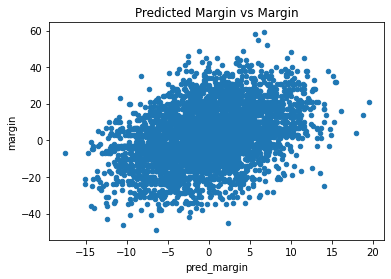

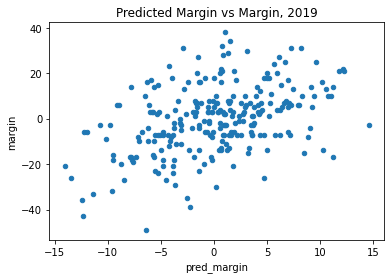

In [7]:
#Plot predicted margin vs margin for all games after 2002
nfl_elo.plot.scatter(x='pred_margin', y='margin', title='Predicted Margin vs Margin')

#Plot predicted margin vs margin for just the 2019 season
nfl_elo.loc[nfl_elo['season'] == 2019].plot.scatter(x='pred_margin', y='margin', title='Predicted Margin vs Margin, 2019')

We can see that teams tend to do better with higher expected margins, but there is a lot of variation. This should be expected as football game scores are pretty hard to predict. Now we will plot the same plot, but color coded based on division. This is achieved by plotting two subplots on top of each other. This plot only shows two seasons, as any more make it crowded and hard to read. 

<AxesSubplot:title={'center':'Predicted Margin vs Margin 2018-2019'}, xlabel='pred_margin', ylabel='margin'>

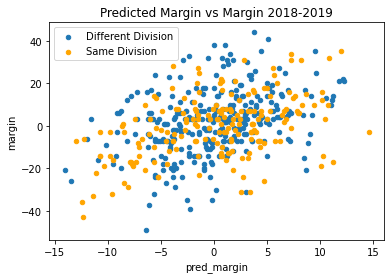

In [8]:
#allow multiple datasets on the same plot
plt.close('all')
fig, ax = plt.subplots()

#Plot predicted margin vs margin colored by whether the game was in-division
nfl_elo.query('season >= 2018 & ~same_division').plot.scatter(x='pred_margin', y='margin', ax=ax, label='Different Division',
                                                             title='Predicted Margin vs Margin 2018-2019')
nfl_elo.query('season >= 2018 & same_division').plot.scatter(x='pred_margin', y='margin', ax=ax, label='Same Division',
                                                             color='orange')

There isn't any obvious difference based on division in this plot. If in-division games were more likely to end in upsets, we would expect to see a weaker correlation between predicted margin and margin for in division games, but that does not appear to be the case.

##### Data Visualization: Win percentage

Win margins are a great way to test prediction accuracy, but at the end of the day all that matters in football is who wins the game. A good prediction should be able to accurately describe a team's chances of winning a game. Ideally teams given a 60% chance of winning should win 60% of games. We can test this directly by putting the data into buckets, and caluclating win percent for each bucket. For example, what percent of teams given a 35%-40% chance to win end up winning? Hopefully about 35 or 40 percent. Below we plot this for with 20 equally sized intervals of 5%. In order to assign buckets to each data point we use [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html), and then use [pandas.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) to calculate the win percent of each bucket. We will plot these win percents in a [bar chart](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html).

<AxesSubplot:title={'center':'Percent of Games Won vs Predicted Win Probability'}, xlabel='Predicted Win%', ylabel='Actual Win%'>

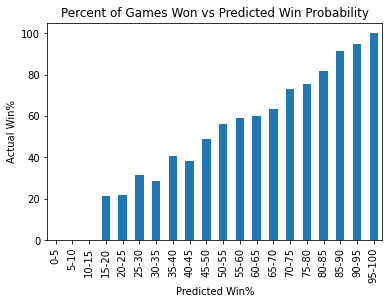

In [9]:
#Create 20 buckets of width 5
buckets = list(range(0, 100, 5))
bucket_labels = [str(i) + '-' + str(i+5) for i in buckets]
buckets.append(100)
buckets = [i/100 for i in buckets]

#Cut the data into the buckets, and label all games with which bucket they are in
nfl_elo['Predicted Win%'] = pd.cut(nfl_elo['prob1'], labels=bucket_labels, bins=buckets)

#Calculate what percent of games team1 won for each bucket
win_pcts = nfl_elo.groupby('Predicted Win%').mean()
win_pcts = win_pcts.reset_index()
win_pcts['result'] = win_pcts['result'].apply(lambda x: x*100)

#Plot the percent of games won for each bucket
win_pcts.plot.bar(x='Predicted Win%', y='result', legend=False, ylabel='Actual Win%', 
                  title='Percent of Games Won vs Predicted Win Probability')

This plot looks pretty good for our predictions. Teams win about as often as they are expected to. Now we again check for a difference between in division and out of division games. This time we achieve the two datasets on one plot by seperately calculating the answer for in division and out of division data. Then we join the two datasets and plot them in one chart.

<AxesSubplot:title={'center':'Percent of Games Won vs Predicted Win Probability'}, xlabel='Predicted Win%', ylabel='Actual Win%'>

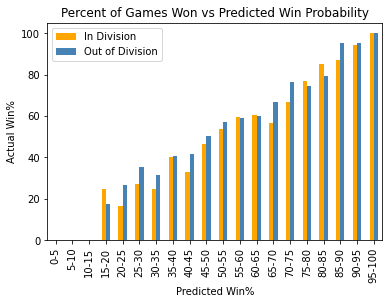

In [10]:
#Repeat the calculations we just did, this time only including in-division games
win_pcts_in = nfl_elo.loc[nfl_elo['same_division']].groupby('Predicted Win%').mean()
win_pcts_in = win_pcts_in.reset_index()
win_pcts_in['result'] = win_pcts_in['result'].apply(lambda x: x*100)
win_pcts_in = win_pcts_in[['Predicted Win%', 'result']]

#Repeat the calculations a third time, using out of division games
win_pcts_out = nfl_elo.loc[nfl_elo['same_division'] == False].groupby('Predicted Win%').mean()
win_pcts_out = win_pcts_out.reset_index()
win_pcts_out['result'] = win_pcts_out['result'].apply(lambda x: x*100)
win_pcts_out = win_pcts_out[['Predicted Win%', 'result']]

#combine and plot
win_pcts_both = pd.merge(win_pcts_in, win_pcts_out, on='Predicted Win%')
win_pcts_both.plot.bar(x='Predicted Win%', y=['result_x', 'result_y'], color=['orange', 'steelblue'], ylabel='Actual Win%',
                       label=['In Division', 'Out of Division'], title='Percent of Games Won vs Predicted Win Probability')


Once again there don't seem to be any obvious differences between our datasets. The data looks a bit noisy, but there are no clear trends. If teams in the same division are more likely to pull off upsets we would expect to see in division teams with low probabilities win more than out of division teams with low probabilities, and vice versa with high win probabilities. Once again we don't really see this in the data.

One piece of information our plots leave out is how many games are included in each bucket. As we will see below, our predictor is relatively cautious and doesn't give many games extreme probabilities like >90% or <10%. To show the distribution of predictions we will make a plot where the height of bars represents how many games are in each bucket. The bars are colored based on how many of those games are wins or losses. To create this plot we will plot the number of wins in each bucket on top of the number of games.

<AxesSubplot:title={'center':'Result of Every Game by Predicted Win Probability'}, xlabel='Predicted Win%', ylabel='# of Games'>

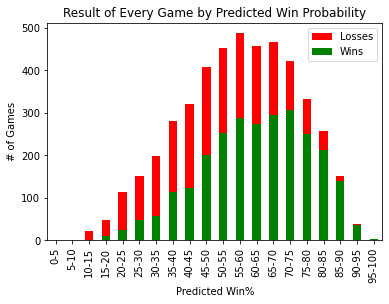

In [11]:
#allow multiple datasets on the same plot
plt.close('all')
fig, ax = plt.subplots()

#Plot total games played for each bucket in red
nfl_elo.groupby('Predicted Win%').count().reset_index().plot.bar(x='Predicted Win%', y='result', ax=ax,  
                                                                 label='Losses', ylabel='# of Games', color='red',
                                                                 title='Result of Every Game by Predicted Win Probability')

#Plot wins for each bucket in green on top of the total games played
nfl_elo.groupby('Predicted Win%').sum().reset_index().plot.bar(x='Predicted Win%', y='result', ax=ax, 
                                                               color='green', label='Wins')

In [12]:
#Bucket labels are no longer needed
nfl_elo = nfl_elo.drop('Predicted Win%', axis=1)

<a name='accuracy'></a>
##### Prediction accuracy

A good way to evaluate our predictions is to test accuracy. This is a very simple measurement that asks whether the team our prediction gave a higher chance of winning ended up winning. It is useful because it has the clearest definintion of an upset: the team that was expected to lose won. If we could only do one test to answer our original question this would be it. 

In [13]:
#Count how many games were predicted correctly and incorrectly
correct = nfl_elo.query('pred_result == result').size
wrong = nfl_elo.query('pred_result != result').size

#Repeat for in division games and out of division games
correct_in = nfl_elo.query('pred_result == result & same_division').size
wrong_in = nfl_elo.query('pred_result != result & same_division').size
correct_out = nfl_elo.query('pred_result == result & ~same_division').size
wrong_out = nfl_elo.query('pred_result != result & ~same_division').size

#calculate accuracy
pct_overall = 100*correct/(correct+wrong)
pct_in = 100*correct_in/(correct_in+wrong_in)
pct_out = 100*correct_out/(correct_out+wrong_out)

print('Overall Accuracy:', pct_overall)
print('In Division Accuracy:', pct_in)
print('Out of Division Accuracy:', pct_out)

Overall Accuracy: 62.673611111111114
In Division Accuracy: 63.19444444444444
Out of Division Accuracy: 62.361111111111114


It turns out in division games are slightly more likely to end with the underdog losing than out of division games. The difference is very small, so it might be noise (we will test this more rigorously below). Whether it is noise or a meaningful relationship, It seems pretty safe to say that upsets are not more common for in division games. The favored team wins 63% of the time in division and 62% of the time out of division.

##### Hypothesis Testing

Our results above left an important question unanswered: is the difference we noticed statistically significant? Put another way, could the difference in underdogs winning be plausibly explained by random chance or should we conclude that there is a meaningful relationship between division and upsets? In order to test this it will be helpful to have a different definition of accuracy. 

Below we define two functions to quantify error, where accuracy is understood as low error. [Logistic error](https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training) is used to quantify the accuracy of binary predictions. In this case we are checking how accurate we are in predicting which team wins. [Square error](https://en.wikipedia.org/wiki/Mean_squared_error) is used to quantify the accuracy of continuous prediction. In this case we will be chacking how accurate our point margin predictions are.

In [14]:
#Calculate log error between predicted and actual categorical data
def log_error(y_pred, y):
    m = y.shape[0]
    errors = np.zeros(m)
    for i in range(m):
        errors[i] = -y[i]*math.log(y_pred[i]) - (1-y[i])*math.log(1-y_pred[i])
    return errors

#Calculate square error between predicted and actual continuous data
def square_error(y_pred, y):
    m = y.shape[0]
    errors = np.zeros(m)
    for i in range(m):
        errors[i] = (y[i]-y_pred[i])**2
    return errors

Now it is time to conduct hypothesis testing. The two questions we will be testing are:

1. Can differences in accuracy between in division and out of division game predictions be explained by random chance?
2. Can differences in accuracy between in division and out of division point spreads be explained by random chance?

These questions might be a bit confusing, so let's step back and see what precisely we will be doing:

###### The T-Test
When we calculated accuracy we saw that in division predictions were slightly more accurate than out of division predictions. We want to see whether that difference is ***[statistically significant](https://en.wikipedia.org/wiki/Statistical_significance)***. If a difference is statistically significant, that means it would be very unlikely to see the difference we see without an underlying cause. If the difference is not statistically significant, that means the difference could easily be explained by random noise in the data.

To test this we are using a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). The t-test calculates the ***[p-value](https://en.wikipedia.org/wiki/P-value)***, which represents the probability of seeing a difference at least as big as we see given that there is no actual relationship. The possibility that there is no relationship between division and accuracy is called the ***[null hypothesis](https://en.wikipedia.org/wiki/Exclusion_of_the_null_hypothesis)*** and the possibility that there is a relationship is called the ***[alternative hypothesis](https://en.wikipedia.org/wiki/Alternative_hypothesis)***. If we find that there is a high chance that we would see data similar to the data we see given no relationship, we say that we have failed to reject the null hypothesis and cannot conlude that there is any relationship between accuracy and division at all. If there is a very small chance of seeing data like we see given no relationship, we say that we have rejected the null hypothesis and conclude that there is a relationship. The most commonly used thershold for statistical significance is 5%. So if p > 5%  we fail to reject the null hypothesis, but if p < 5%, we reject the null hypothesis. 

We will be conducting two t-tests: one for predicted game results and one for predicted margins. In both cases we will be comparing errors of in-division games to errors of out of divison games. Higher errors mean predictions are less accurate, which means upsets are more common.

In [15]:
#These are the two datasets we will be comparing with t-tests
same_div = nfl_elo.loc[nfl_elo['same_division']]
diff_div = nfl_elo.loc[nfl_elo['same_division'] == False]

#Calculate log error for both datasets
same_log_error = log_error(same_div['prob1'].to_numpy(), same_div['result'].to_numpy())
diff_log_error = log_error(diff_div['prob1'].to_numpy(), diff_div['result'].to_numpy())

#Preform a t-test on log error 
log_results = stats.ttest_ind(same_log_error, diff_log_error)

#Calculate square error for both datasets
same_square_error = square_error(same_div['pred_margin'].to_numpy(), same_div['margin'].to_numpy())
diff_square_error = square_error(diff_div['pred_margin'].to_numpy(), diff_div['margin'].to_numpy())

#Preform a t-test on square error 
square_results = stats.ttest_ind(same_square_error, diff_square_error)

print('Game Result Log Error p-value:', log_results[1])
print('Point Margin Square Error p-value:', square_results[1])

Game Result Log Error p-value: 0.4085243629181847
Point Margin Square Error p-value: 0.07299930085432252


In both cases, our p-value is above 5%, so we fail to reject the null hypothesis. That means we cannot conclude that there is any relationship between division and accuracy of predictions.

<a name='prediction'></a>
## Prediction

The last thing to do with our data is to predict other data. We will use [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) and [linear regression](https://en.wikipedia.org/wiki/Linear_regression) on Elo scores ignoring division and then including division. To evaluate our regression we will use [ten fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). This randomly divides our dataset into 10 part. The regression model is trained on 9 of the parts and then tested on the 10th. This is repeated 10 times so that the model is tested on all 10 parts of the data. We then average the score from the testing across all 10 parts.

So what is the score? For logistic regression we use accuracy% as a score. This is exactly the same accuracy calculation we did [earlier](#accuracy): how often did the favored team win? For linear regression we use [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) as the score. R-squared determines how much varience in y is explained by X. For example, if R-squared = 40 then we can explain 40% of the varience in teams winning from their Elo scores.

Before we start regression, we have to prepare the data we will be regressing on:

In [16]:
#Convert results to a boolean variable and same_division to an int
nfl_elo['team1_won'] = nfl_elo['margin'].apply(lambda x: x > 0)
nfl_elo['same_division_int'] = nfl_elo['same_division'].apply(lambda x: 1 if x else 0)

#Choose X and y
X_elo = nfl_elo.loc[:, ['elo1', 'elo2']]
X_elo_div = nfl_elo.loc[:, ['elo1', 'elo2', 'same_division_int']]
y_result = nfl_elo.loc[:, 'team1_won']
y_margin = nfl_elo.loc[:, 'margin']

Now we can run our first regression. Here we run logistic regression using only the two team's Elo ratings

In [17]:
win_predictor = LogisticRegression().fit(X_elo, y_result)
win_scores = cross_val_score(win_predictor, X_elo, y_result, cv=10)
print('Accuracy without division:', win_scores.mean()*100)

Accuracy without division: 64.84424219560502


Next we run the same regression but in addition to Elo ratings we also train on whether the teams are in the same division

In [18]:
win_predictor = LogisticRegression().fit(X_elo_div, y_result)
win_scores = cross_val_score(win_predictor, X_elo_div, y_result, cv=10)
print('Accuracy with division:', win_scores.mean()*100)

Accuracy with division: 64.5618692822786


The accuracy of our predictor is almost exactly the same with or without knowledge of division. This means that knowing whether two teams are in the same division is completely useless when predicting who will win using our logitic regressor.

Something else to note is that our accuracy of 65% is only slightly better than the 63% accuracy we got from just using the built in Elo formula. This might suggest that the built in formula is as good as you can do with Elo ratings. An interesting follow-up project would be to check whether the difference in accuracy between the built-in Elo prediction formula and linear regression is statistically significant.

Now we move on to linear regression on margin of victory. We are using the same features to predict the margin, but because margin is a continuous value we use linear regression instead of logistic regession.

In [19]:
margin_predictor = LinearRegression().fit(X_elo, y_margin)
margin_scores = cross_val_score(margin_predictor, X_elo, y_margin, cv=10)
print('R-squared without division:', margin_scores.mean()*100)

R-squared without division: 14.140889871082493


Once again we will repeat the linear regression, this time including division information.

In [20]:
margin_predictor = LinearRegression().fit(X_elo_div, y_margin)
margin_scores = cross_val_score(margin_predictor, X_elo_div, y_margin, cv=10)
print('R-squared without division:', margin_scores.mean()*100)

R-squared without division: 14.279448891193134


Just like with logistic regression, there is basically no difference between our regressor with or without division information. It is interesting that we were able to achieve 65% accuracy in predicting game results, but we can only explain 14% of variation in score margin. This suggests that score margin is highly varied and hard to predict, something we saw earlier in the [scatter plot](#scatter) of predicted margin vs margin. We never calculated R-squared for Elo's built-in margin predictor, but it would be an interesting follow up project to do that and test whether our linear regression is significantly better than that.

<a name='conclusion'></a>
## Conclusion

The question we set out to answer at the beginning was whether teams were more likely to pull off upsets against in-division opponents than out of division opponents. We used data visualizations, accuracy calculations, hypothesis testing, and machine learning to find an answer. In all cases we got the same result: There is pretty much no relationship between whether a game is played inside a division and whether the underdog wins. This may seem like a disappointing result, but it is a useful result. Sometimes our intuition and common knowledge is wrong. When conventional wisdom is wrong about something like this we need a way to rigerously determine the truth. This is what data science is for!

During our exploration of this question we found some other questions that can be expanded upon in future analysis. Our Elo ratings come with a built in method for calculation win probability and points margin. Using machine learning we got what appeared to be slightly better results. Are these results actually better, or is this just random noise? We would need to do hypothesis testing to find out. What about other methods of machine learning?  Sk-learn has lots of [options](https://scikitlearnjl.readthedocs.io/en/latest/models/) to choose from. 

There are a lot of other, more general questions we can also ask: If division doesn't influence the results of games, is there anything else that does? Is it possible to explain more than 14% of the varience in score margin? Can we beat 538's predictions over the long run? 

Hopefully the knowlegde you gained from this tutorial will be useful should you try to answer these questions, or any other questions you need data science to answer.